In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
import io
from keras import backend
from keras.models import Sequential
from keras.layers import LSTM,BatchNormalization
from keras.layers.core import Dense, Activation, Dropout
%matplotlib inline

Using TensorFlow backend.


In [2]:
# load all files
black = pd.read_csv('blackscholes.csv')
dedup = pd.read_csv('dedup.csv')
fft = pd.read_csv('fft.csv')
freq = pd.read_csv('freqmine.csv')
luindex = pd.read_csv('luindex.csv')
pmd = pd.read_csv('pmd.csv')

In [3]:
# Concatenate all of the csv files together
full_data = [black, dedup, fft, freq, luindex, pmd]
full_con = pd.concat(full_data)

In [4]:
# Grab necessary data and set the date as the index
final_full = full_con[['date', 'DISTSIM_BENCH.benchmark_id', 'DISTSIM_BENCH.host_L2_BW', 'DISTSIM_BENCH.host_L3_BW', 'DISTSIM_BENCH.host_L3_SYSTEM_BW', 'DISTSIM_BENCH.host_MEM_BW', 'DISTSIM_BENCH.host_context_switch', 'DISTSIM_BENCH.host_cpupercent', 'DISTSIM_BENCH.host_disk_io', 'DISTSIM_BENCH.host_disk_io_time', 'DISTSIM_BENCH.host_disk_weighted_io_time', 'DISTSIM_BENCH.host_memory', 'DISTSIM_BENCH.host_network', 'DISTSIM_BENCH.latency']] #, 'DISTSIM_BENCH.latency90'
final_full = final_full.set_index('date')

In [15]:
# Helper function that return original values and values shifted by 1
def helper(data):
    numVars = data.shape[1]
    dfData = pd.DataFrame(data)
    col, colName = list(), list()
    # input sequence
    for i in range(1, 0, -1):
        col.append(dfData.shift(i))
        colName += [('var%d(t)' % (j+1)) for j in range(numVars)]
    # forecast sequence
    for i in range(0, 1):
        col.append(dfData.shift(-i))
        colName += [('var%d(t+%d)' % (j+1, i+1)) for j in range(numVars)]

    finalCol = pd.concat(col, axis=1)
    finalCol.columns = colName
    finalCol.dropna(inplace=True)
    return finalCol

In [26]:
# Label encode the values, normalize all of the values between 0 and 1, and call helper to shift values
values = final_full.values
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
supervise = helper(scaled)
supervise.head()

#Multiple value predictor
supervise.drop(supervise.columns[[13,14,15,16,17,18,20,21,22,23,24]], axis=1, inplace=True)
#Cpu percent predictor
#supervise.drop(supervise.columns[[13,14,15,16,17,18,20,21,22,23,24,25]], axis=1, inplace=True)
# Latency Predictor
#supervise.drop(supervise.columns[[13,14,15,16,17,18,19,20,21,22,23,24]], axis=1, inplace=True)
supervise.head()

,var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var7(t+1),var13(t+1)
1,0.833333,0.999977,0.999976,0.067093,0.059138,0.155348,0.106934,0.005319,0.037464,0.001547,0.907123,0.062474,0.000000,0.155152,0.075646
2,0.166667,0.999979,0.999977,0.056380,0.052499,0.305988,0.155152,0.019838,0.053312,0.001673,0.908850,0.065829,0.075646,0.160805,0.077491
3,0.166667,0.999986,0.999985,0.167290,0.092629,0.272564,0.160805,0.025156,0.057636,0.052191,0.898668,0.058958,0.077491,0.160719,0.081181
4,0.166667,0.999979,0.999978,0.248954,0.115559,0.290274,0.160719,0.019119,0.063400,0.017271,0.908454,0.060413,0.081181,0.152691,0.079336
5,0.166667,0.999977,0.999975,0.253455,0.121887,0.302097,0.152691,0.014950,0.043227,0.002593,0.909971,0.043108,0.079336,0.166704,0.086716


In [34]:
# Split into train and test set
train_size = int(0.9*len(supervise))
sup_values = supervise.values
train = sup_values[:train_size, :]
test = sup_values[train_size:, :]

# # Split into input (X) and output (y) for single predictor
# train_X = train[:,:-1]
# train_y = train[:,-1]
# test_X = test[:,:-1]
# test_y = test[:,-1]

# Split into input (X) and output (y) for multiple predictor
train_X = train[:,:-2]
train_y = train[:,-2]
test_X = test[:,:-2]
test_y = test[:,-2]

# Change to necessary for LSTM model
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_y)

(1620, 1, 13) (1620,) (180, 1, 13) (180,)
[0.1551522  0.16080466 0.16071871 ... 0.9884265  0.9910163  0.98865217]


In [20]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [21]:
# Function to create model
def createLSTM(x, loss):
    model = Sequential()
    # layer 1: LSTM
    model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dropout(0.5))
    # layer 2: LSTM
    model.add(LSTM(200, return_sequences=False))
    model.add(Dropout(0.5))
    
    # layer 3: fully-connected
    model.add(Dense(activation='relu', units=500))
    model.add(Dropout(0.5))

    # output
    model.add(Dense(1))
    model.compile(loss=loss, optimizer='adamax',metrics=[rmse, 'mse'])
    return model
    

In [ ]:
# Function to create model
def createLSTM2(x, loss):
    model = Sequential()
    # layer 1: LSTM
    model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    # layer 2: LSTM
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(0.2))
    
    # layer 3: fully-connected
    model.add(Dense(activation='relu', units=500))
    model.add(Dropout(0.5))

    # output
    model.add(Dense(1))
    model.compile(loss=loss, optimizer='adamax',metrics=[rmse, 'mse'])
    return model

Train on 1620 samples, validate on 180 samples
Epoch 1/80
 - 2s - loss: 0.0958 - rmse: 0.2504 - mean_squared_error: 0.0958 - val_loss: 0.0181 - val_rmse: 0.1197 - val_mean_squared_error: 0.0181
Epoch 2/80
 - 1s - loss: 0.0156 - rmse: 0.0975 - mean_squared_error: 0.0156 - val_loss: 0.0017 - val_rmse: 0.0365 - val_mean_squared_error: 0.0017
Epoch 3/80
 - 1s - loss: 0.0143 - rmse: 0.0913 - mean_squared_error: 0.0143 - val_loss: 0.0020 - val_rmse: 0.0397 - val_mean_squared_error: 0.0020
Epoch 4/80
 - 1s - loss: 0.0110 - rmse: 0.0784 - mean_squared_error: 0.0110 - val_loss: 0.0020 - val_rmse: 0.0397 - val_mean_squared_error: 0.0020
Epoch 5/80
 - 1s - loss: 0.0098 - rmse: 0.0754 - mean_squared_error: 0.0098 - val_loss: 0.0017 - val_rmse: 0.0364 - val_mean_squared_error: 0.0017
Epoch 6/80
 - 1s - loss: 0.0090 - rmse: 0.0714 - mean_squared_error: 0.0090 - val_loss: 0.0010 - val_rmse: 0.0276 - val_mean_squared_error: 0.0010
Epoch 7/80
 - 1s - loss: 0.0098 - rmse: 0.0751 - mean_squared_error: 0.

Epoch 55/80
 - 1s - loss: 0.0059 - rmse: 0.0582 - mean_squared_error: 0.0059 - val_loss: 9.9971e-04 - val_rmse: 0.0261 - val_mean_squared_error: 9.9971e-04
Epoch 56/80
 - 1s - loss: 0.0067 - rmse: 0.0619 - mean_squared_error: 0.0067 - val_loss: 9.4343e-04 - val_rmse: 0.0231 - val_mean_squared_error: 9.4343e-04
Epoch 57/80
 - 1s - loss: 0.0065 - rmse: 0.0618 - mean_squared_error: 0.0065 - val_loss: 9.7663e-04 - val_rmse: 0.0235 - val_mean_squared_error: 9.7663e-04
Epoch 58/80
 - 1s - loss: 0.0058 - rmse: 0.0576 - mean_squared_error: 0.0058 - val_loss: 0.0017 - val_rmse: 0.0362 - val_mean_squared_error: 0.0017
Epoch 59/80
 - 1s - loss: 0.0054 - rmse: 0.0560 - mean_squared_error: 0.0054 - val_loss: 8.8943e-04 - val_rmse: 0.0195 - val_mean_squared_error: 8.8943e-04
Epoch 60/80
 - 1s - loss: 0.0044 - rmse: 0.0502 - mean_squared_error: 0.0044 - val_loss: 0.0012 - val_rmse: 0.0288 - val_mean_squared_error: 0.0012
Epoch 61/80
 - 1s - loss: 0.0049 - rmse: 0.0533 - mean_squared_error: 0.0049 - v

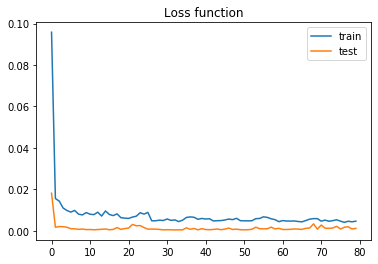

2 LSTM layers with 300 and 200 units respectively and dropout of 0.5
Third layer is fully connected with activation relu, 500 units, and dropout of 0.5
Output layer with Adamax optimizer
180/180 [==============================] - 0s 79us/step
mean_squared_error[0.0011561010860734516, 0.027416057305203544, 0.0011561010860734516]


In [22]:
loss='mean_squared_error'
model = createLSTM2(train_X,loss)
# fit network
history = model.fit(train_X, train_y, epochs=80, batch_size=36, validation_data=(test_X,test_y), verbose=2, shuffle=False)

# plot history (loss and validation loss)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Loss function")
plt.legend()
plt.show()
print("2 LSTM layers with 300 and 200 units respectively and dropout of 0.5")
print("Third layer is fully connected with activation relu, 500 units, and dropout of 0.5")
print("Output layer with Adamax optimizer")

modelName = loss+'LSTM150.h5'
model.save(modelName)
#
# evaluate the result
test_mse = model.evaluate(test_X, test_y, verbose=1)
print(loss+str(test_mse))

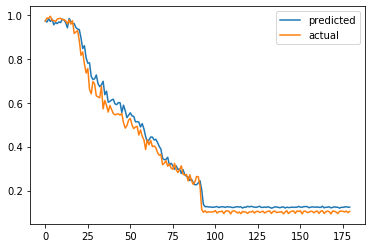

In [23]:
# PLot the predicted vs the actual values
yhat = model.predict(test_X)
plt.plot(yhat, label="predicted")
plt.plot(test_y, label='actual')
plt.legend()
plt.show()